<a href="https://colab.research.google.com/github/MehrdadJalali-AI/BlackHoles/blob/main/PLots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

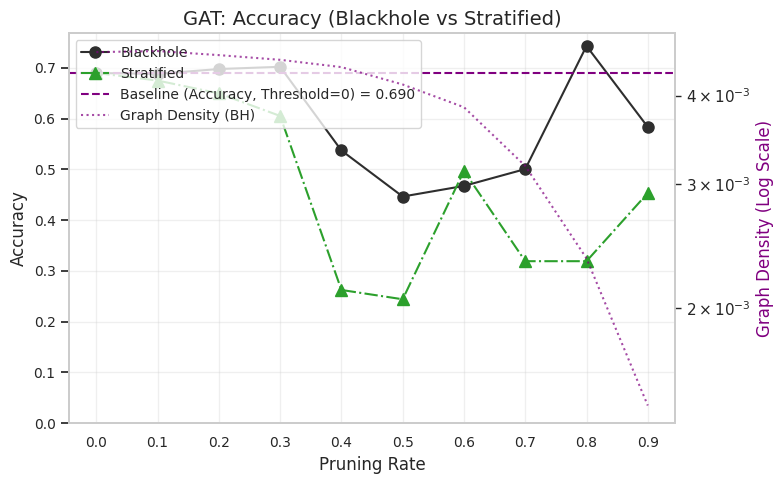

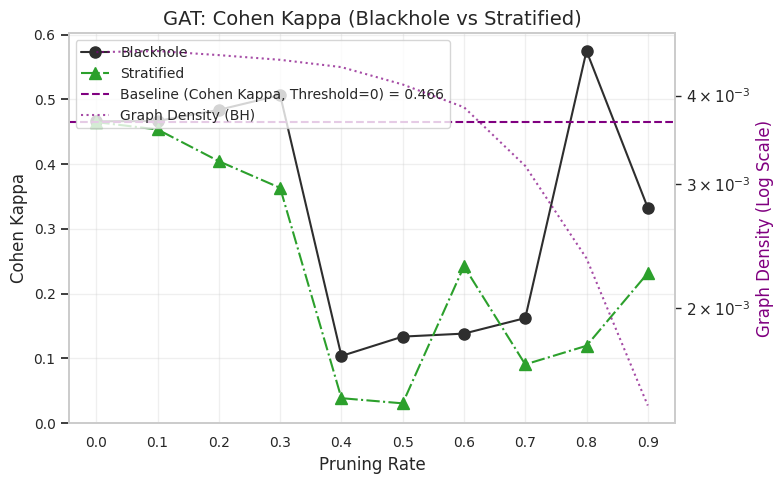

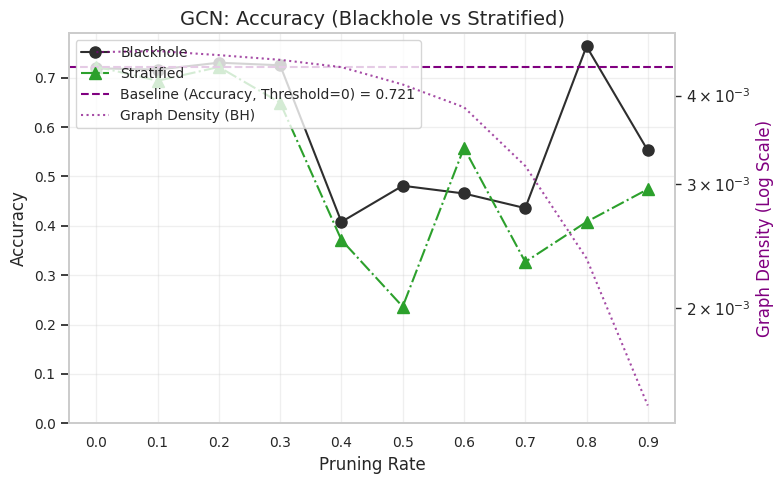

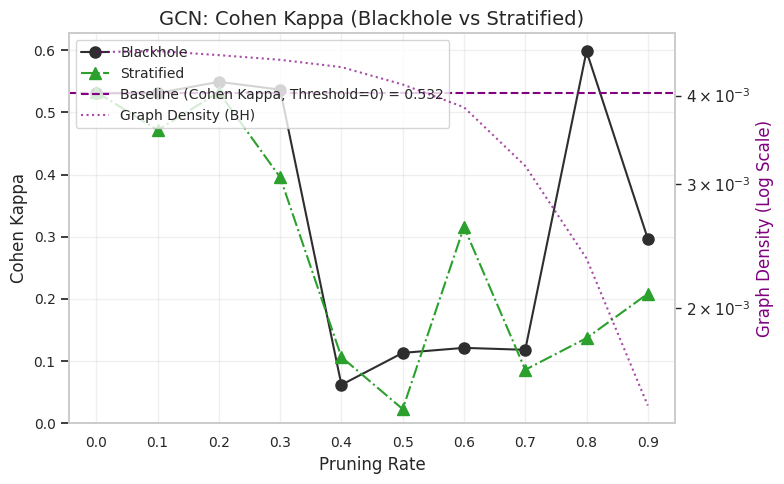

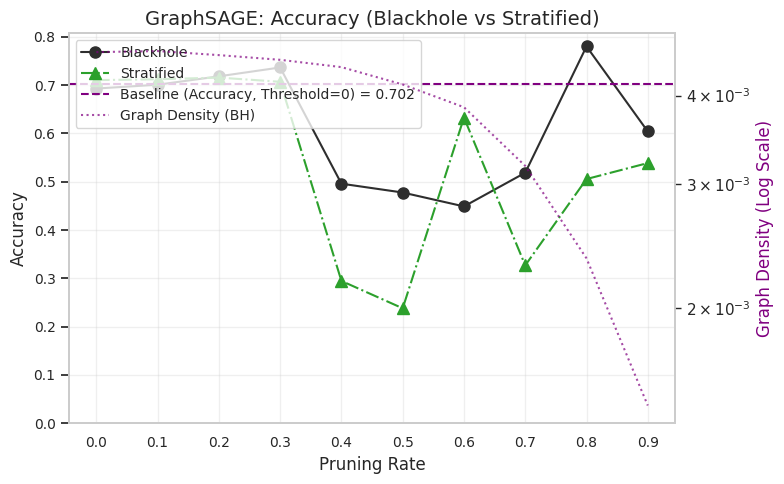

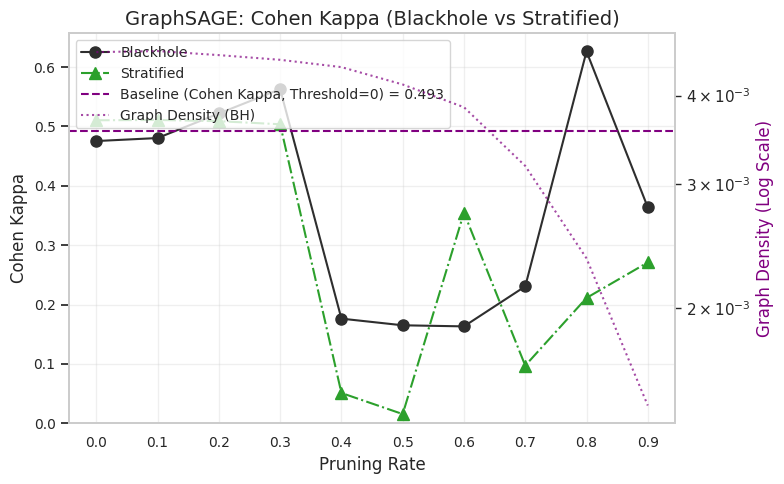

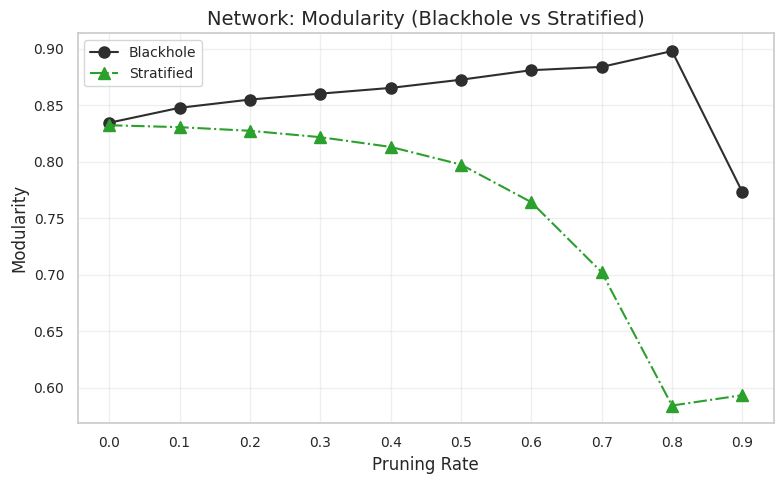

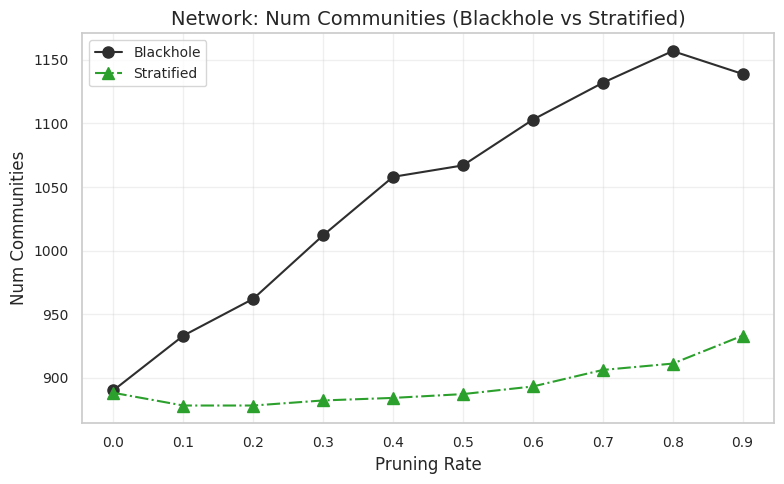

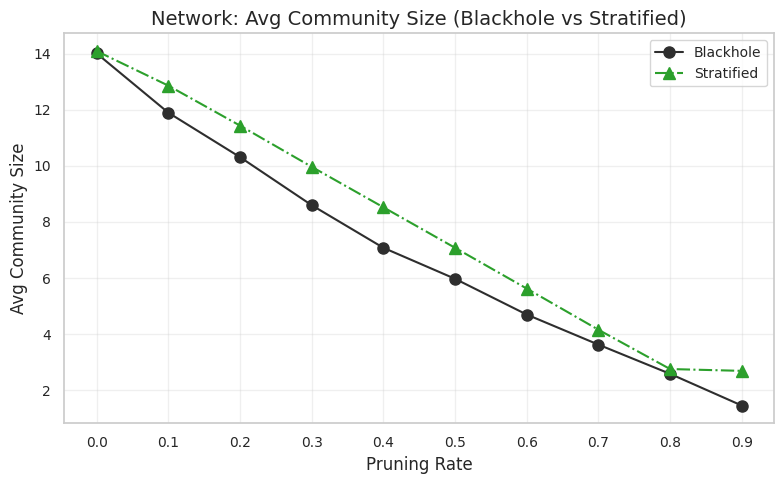

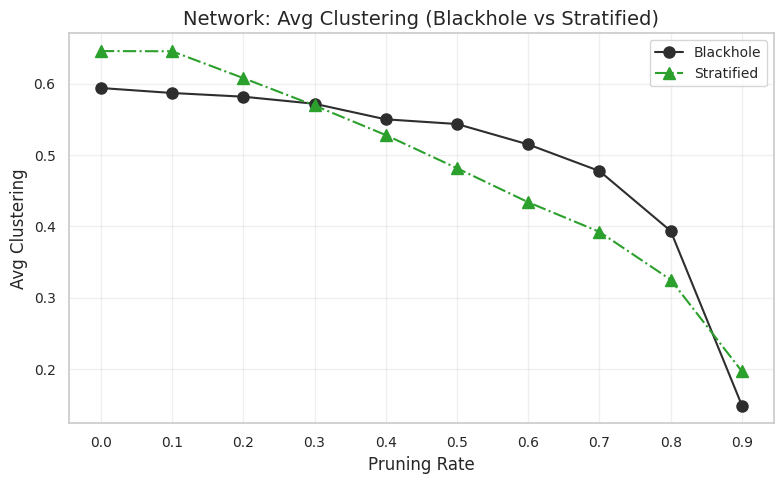

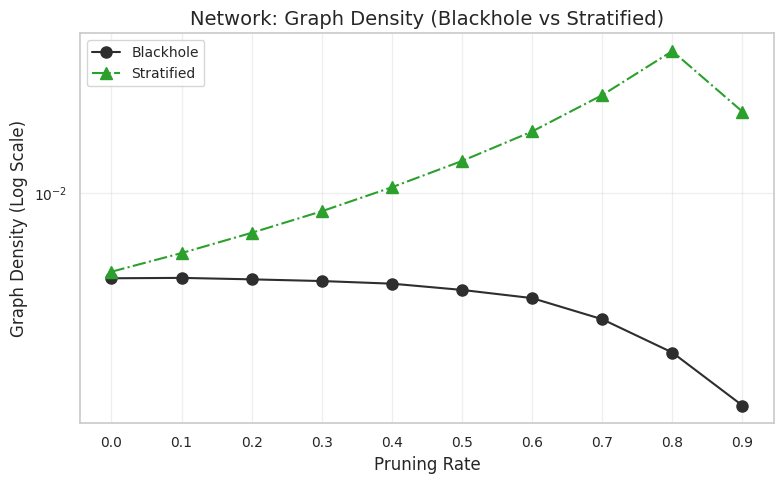

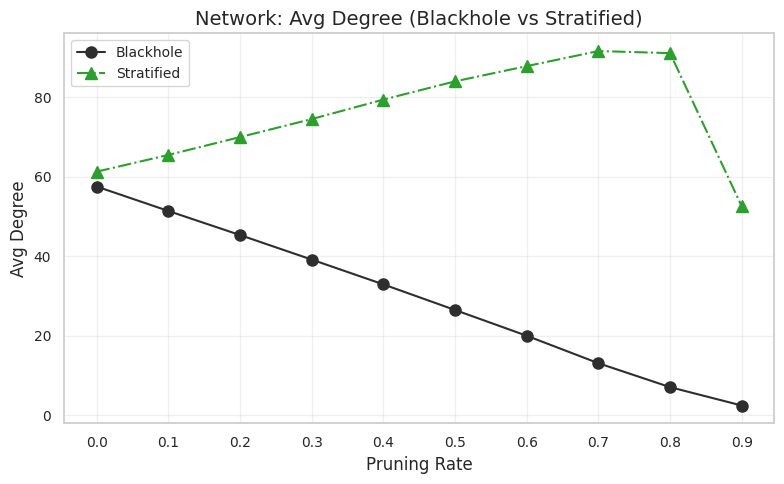

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_Mean                     Cohen_Kappa_Mean  \
Model                          GAT       GCN GraphSAGE              GAT   
Threshold Method                                                          
0.0       blackhole       0.689625  0.719268  0.693112         0.466205   
          stratified      0.689625  0.722755  0.710549         0.465003   
0.1       blackhole       0.687881  0.716652  0.700959         0.466729   
          stratified      0.674804  0.693984  0.712293         0.453627   
0.2       blackhole       0.697472  0.730602  0.718396         0.483946   
          stratified      0.649520  0.721883  0.715780         0.404592   
0.3       blackhole       0.701831  0.725371  0.736704         0.506781   
          stratified      0.605057  0.649520  0.707062         0.363409   
0.4       blackhole       0.537053  0.408021  0.496077         0.103881   
          stratified      0.262424  0.371404 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'stratified': '^'
}

# Load data from the provided CSV content (saved as results_aggregated3.csv)
df = pd.read_csv('results_aggregated.csv')

# Calculate SEM for performance metrics (assuming num_runs=1)
df['Accuracy_sem'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_sem'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_sem')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std')
]

# Models and thresholds
models = df['Model'].unique()
threshold_values = sorted(df['Threshold'].unique())  # Using all available thresholds: 0.0 to 0.9

# Font sizes
label_fontsize = 12
tick_fontsize = 10
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, strat_mean, strat_sem):
    return bh_mean - bh_sem > strat_mean + strat_sem

# Plotting function for pairwise comparisons (blackhole vs stratified)
def plot_pairwise_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        ax.fill_between(method_data['Threshold'],
                        method_data[metric] - method_data[std_metric],
                        method_data[metric] + method_data[std_metric],
                        alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
       # Force y-axis to start at 0 for accuracy and kappa

        ax.set_ylim(bottom=0)
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_Mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for thresh in threshold_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Threshold'] == thresh)]
            if not (bh_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_sem'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_sem'].values[0]
                if is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name} (Blackhole vs Stratified)', fontsize=title_fontsize)
    ax.set_xlabel('Pruning Rate', fontsize=label_fontsize)
    ax.set_ylabel(metric_name, fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')
        ax.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize)

    # Add baseline for performance metrics
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        baseline = subset[subset['Threshold'] == 0.0][metric].mean()
        ax.axhline(y=baseline, color='purple', linestyle='--',
                   label=f'Baseline ({metric_name}, Threshold=0) = {baseline:.3f}')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    plt.tight_layout()
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_pairwise_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (using GAT data as representative)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_pairwise_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Stratified
distances_bh_stratified = []

for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_stratified.append((dist_bh_stratified, thresh, model, bh_acc, strat_acc))

# Find maximum and minimum distances
max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_sem', 'Cohen_Kappa_Mean', 'Cohen_Kappa_sem'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_sem'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_sem'].values[0]
            if is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((thresh, model, bh_acc, strat_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms Stratified (Accuracy):")
    for thresh, model, bh_acc, strat_acc in bh_outperform:
        print(f"- Threshold {thresh:.1f}, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Stratified = {strat_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Threshold {max_dist_bh_stratified[1]:.1f}, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Threshold {min_dist_bh_stratified[1]:.1f}, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracyå
max_acc_row = df.loc[df['Accuracy_Mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_Mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.1f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_Mean']:.6f}")

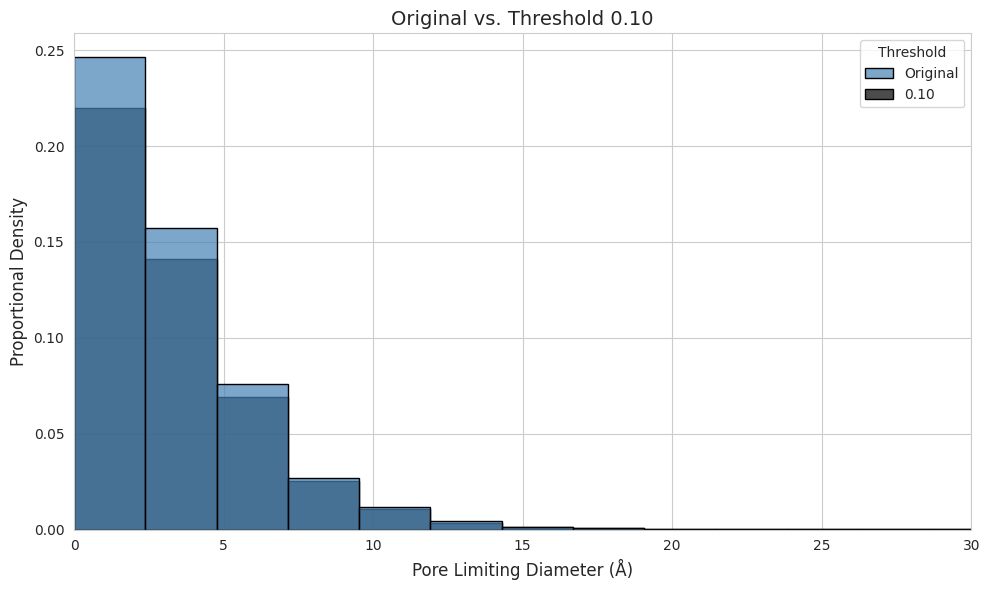

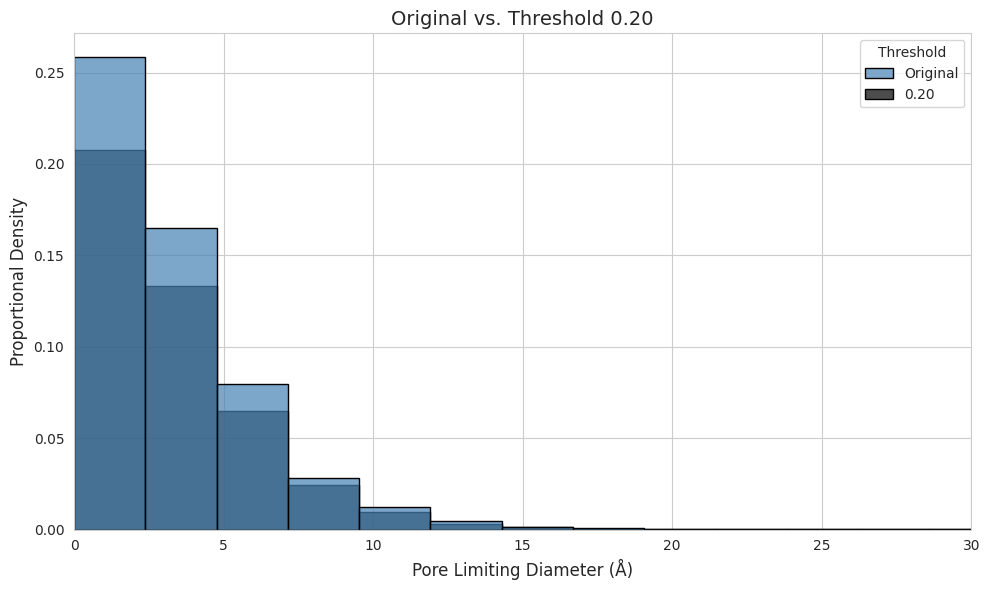

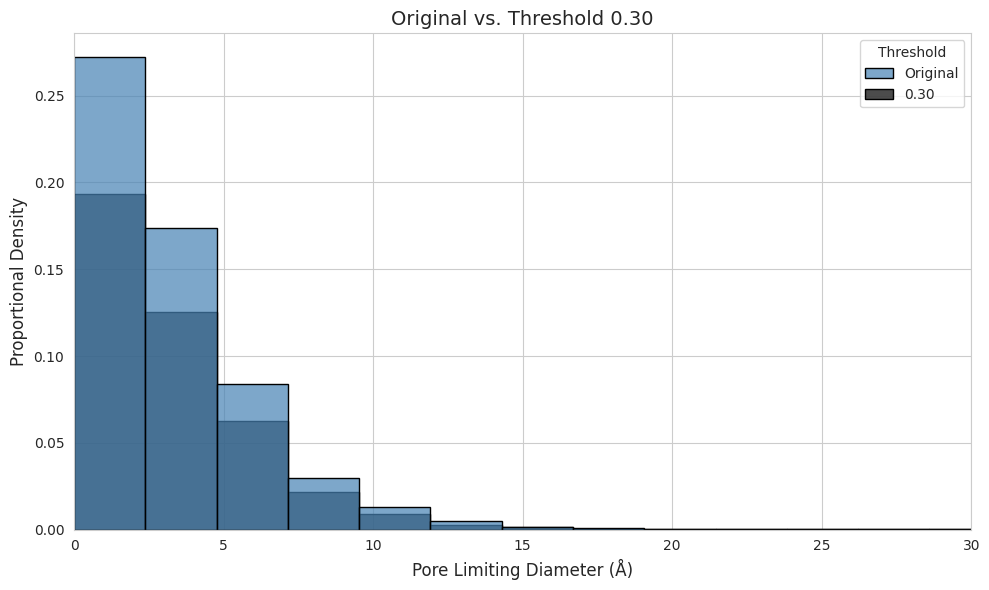

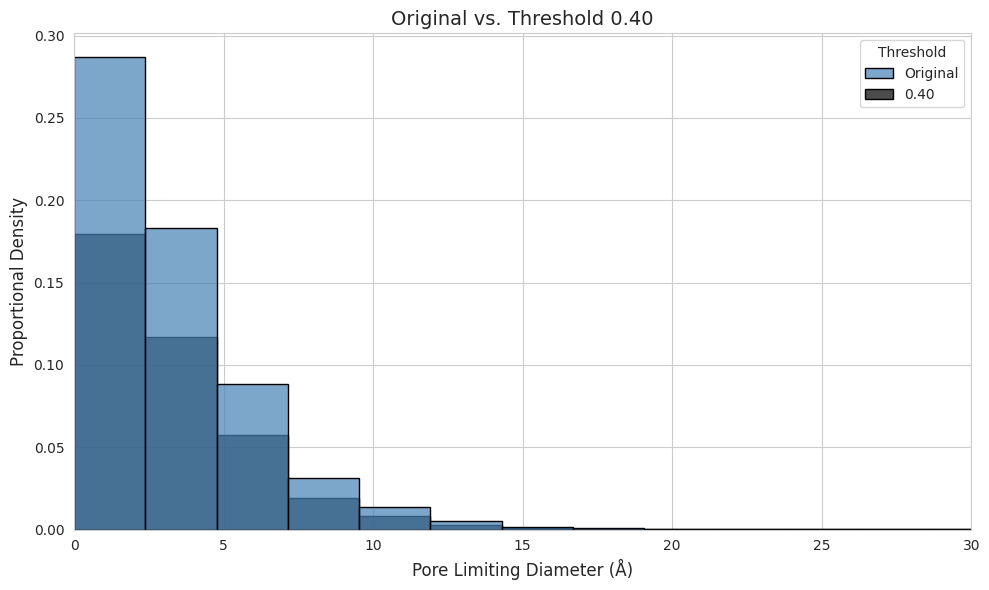

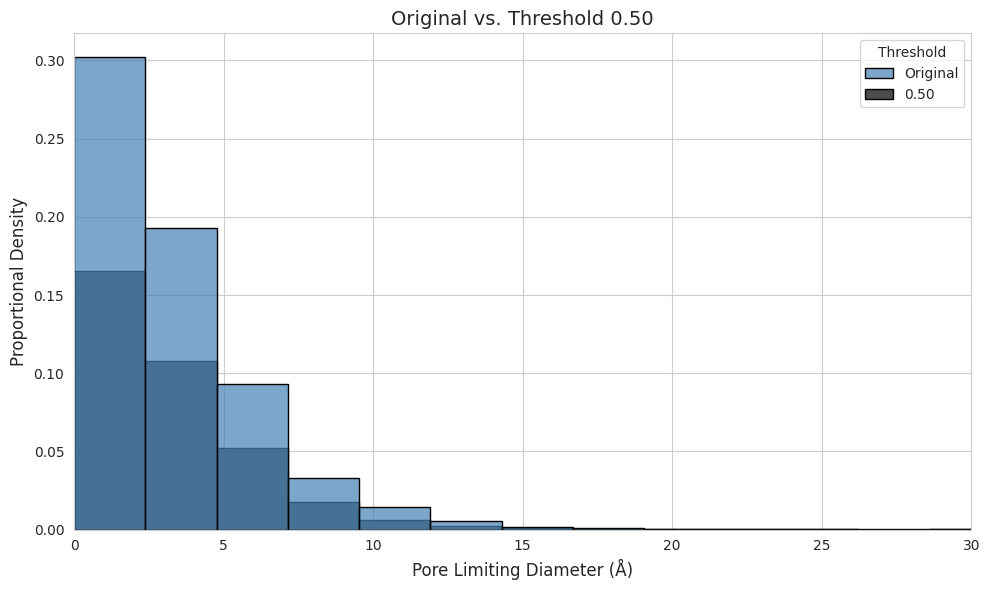

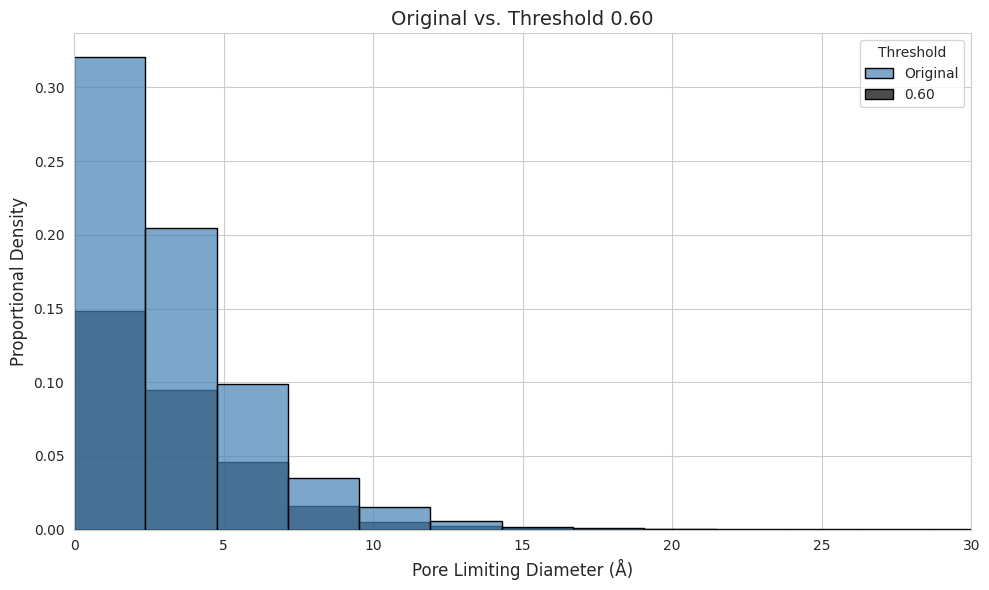

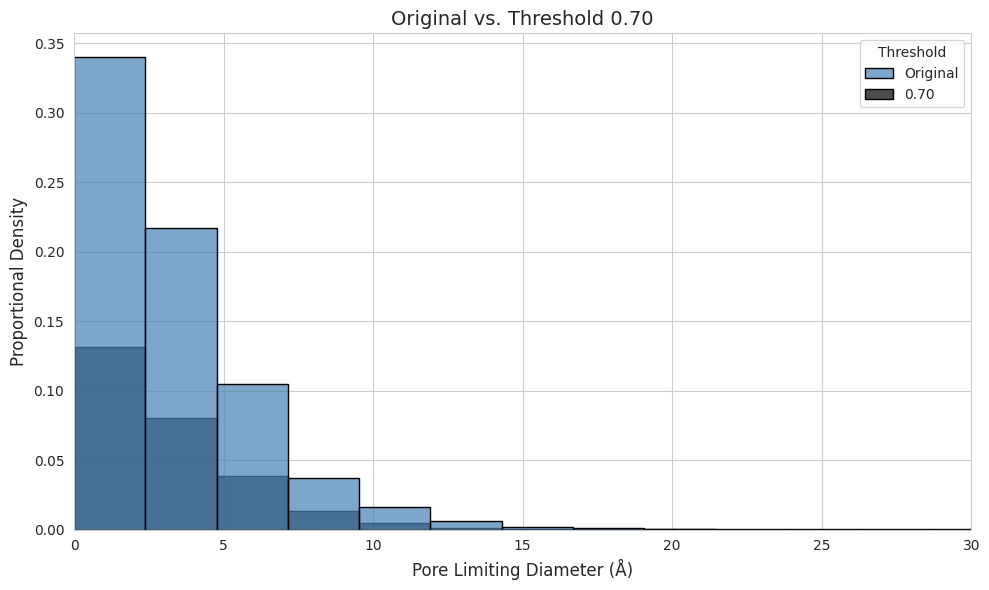

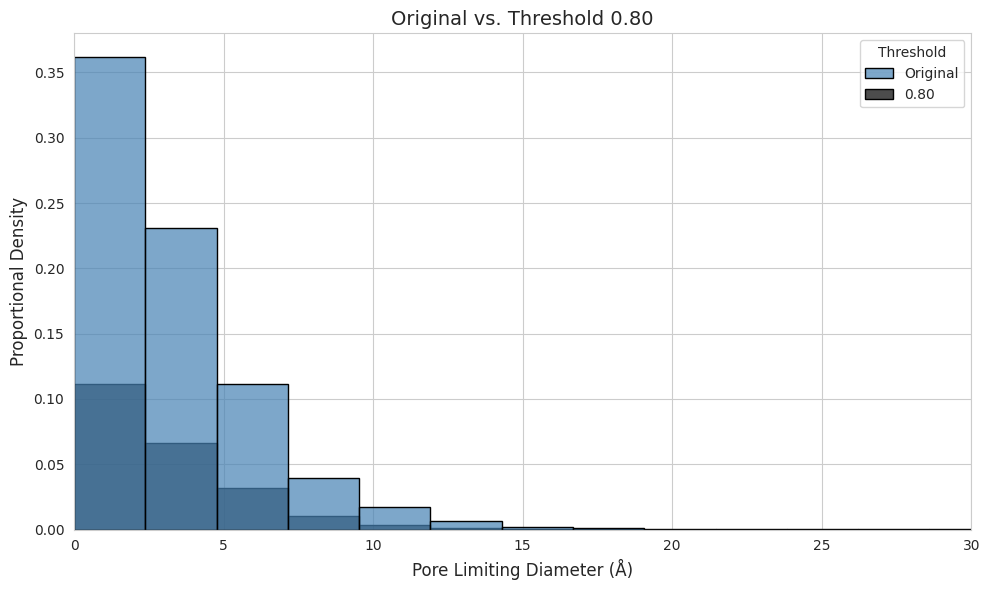

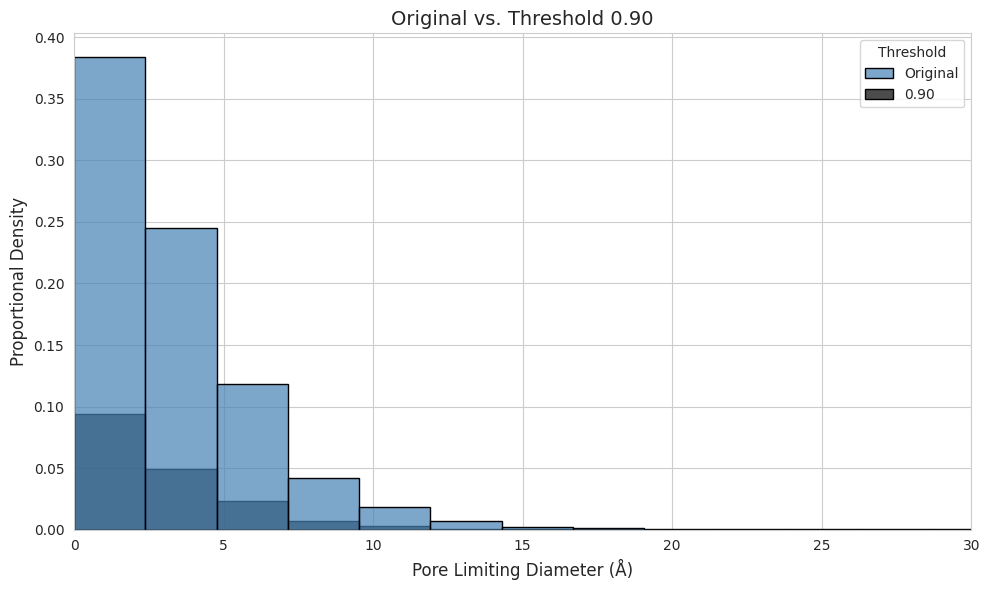

Plots displayed successfully.


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the folder path and file pattern
folder_path = "BH_Datasets"
thresholds = ['0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90']
file_prefix = "remaining_node_features_t"
file_suffix = "_r0.csv"

# Load the original dataset (threshold 0.00)
original_file = os.path.join(folder_path, f"{file_prefix}0.00{file_suffix}")
if not os.path.exists(original_file):
    print(f"Original file {original_file} not found. Exiting.")
    exit()

original_df = pd.read_csv(original_file)
original_df['Threshold'] = 'Original'

# Set white background and grid
plt.style.use('default')
sns.set_style("whitegrid")

# Loop through each threshold and create a plot
for thresh in thresholds:
    file_name = os.path.join(folder_path, f"{file_prefix}{thresh}{file_suffix}")
    if not os.path.exists(file_name):
        print(f"File {file_name} not found. Skipping threshold {thresh}.")
        continue

    # Format clean label like "0.80"
    label = thresh

    # Load thresholded dataset and set label
    thresh_df = pd.read_csv(file_name)
    thresh_df['Threshold'] = label

    # Combine with original data
    combined_df = pd.concat([
        original_df[['Pore Limiting Diameter', 'Threshold']],
        thresh_df[['Pore Limiting Diameter', 'Threshold']]
    ], ignore_index=True)

    # Custom color palette
    palette = {
        'Original': '#4682B4',  # SteelBlue
        label: 'black'          # Black for BH thresholded
    }

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_df, x='Pore Limiting Diameter', hue='Threshold',
                 stat='probability', bins=30, alpha=0.7, edgecolor='black',
                 palette=palette)

    # Customize plot
    plt.title(f'Original vs. Threshold {label}', fontsize=14)
    plt.xlabel('Pore Limiting Diameter (Å)', fontsize=12)
    plt.ylabel('Proportional Density', fontsize=12)
    plt.xlim(0, 30)  # Limit x-axis to 40


    # Display
    plt.tight_layout()
    plt.show()

print("Plots displayed successfully.")
